In [34]:
import os
import sys
import json
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import json



# Named Entity Recognition & Image Classification Pipeline

This notebook presents an overview of the AI pipeline for Named Entity Recognition (NER) and Image Classification. The goal is to extract animal names from text and verify if they match the detected object in an image.

---

## 1. Exploratory Data Analysis (EDA)

To understand the dataset, let's analyze it.


### Animal-10 images Dataset

In this project, we use an **animal classification dataset**, which consists of images organized into **10 class folders**, each representing a different animal species.

#### Why this dataset?
- **Multi-class diversity:** The dataset includes at least 10 different animal categories, allowing us to train a image classification model.
- **Real-world applicability:** It provides a good variety of images, helping our model generalize well in practical scenarios.
- **Balanced structure:** The dataset is structured with a clear separation of classes.
- **Classes of animals** in this dataset: dog, cat, sheep, cow, zebra, squirrel, butterfly, chicken, elephant, horse

Below, we randomly select and display **five sample images** from the dataset to visually inspect its content and ensure its correctness.


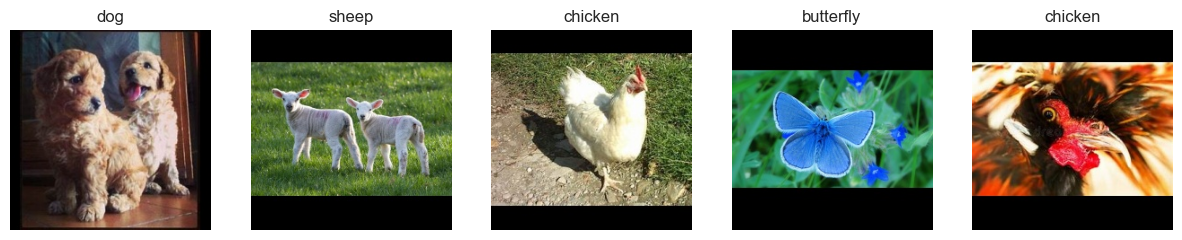

In [35]:
dataset_path = "data/img/images_preprocessed"
all_images = [os.path.join(root, file) for root, _, files in os.walk(dataset_path) for file in files]

sample_images = random.sample(all_images, min(5, len(all_images)))

fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
for ax, img_path in zip(axes, sample_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(os.path.basename(os.path.dirname(img_path)))
    ax.axis("off")
plt.show()


### Named Entity Recognition (NER) Dataset Overview

For training our **Named Entity Recognition (NER) model**, we created a synthetic dataset using a **template-based generator**. This dataset consists of **annotated sentences**, where each sentence contains an animal name that is labeled as a named entity.

#### Why this dataset?
- **Controlled and structured data:** The sentences are generated using predefined templates, ensuring high-quality labels.
- **Balanced entity distribution:** Each of the **10 animal categories** appears equally across the dataset.
- **Diverse sentence structures:** The templates introduce variability, preventing overfitting to specific phrases.

The dataset is **split into three parts**:
- **Train (70%)** – used for model training.
- **Validation (20%)** – used for hyperparameter tuning.
- **Test (10%)** – used for final model evaluation.

Below, we display a few randomly selected annotated sentences from the dataset.


In [36]:
# Load the generated dataset
dataset_path = "data/ner/generated_animal_dataset.json"
with open(dataset_path, "r") as f:
    dataset = json.load(f)

# Select random sentences from the training set
sample_sentences = random.sample(dataset["train"], min(5, len(dataset["train"])))

# Display sentences and their annotations
for sample in sample_sentences:
    print("Sentence:", " ".join(sample["tokens"]))
    print("Labels:  ", " ".join(sample["labels"]))
    print("-" * 80)

Sentence: The horse was standing near the lake.
Labels:   O B-HORSE O O O O O
--------------------------------------------------------------------------------
Sentence: The zoo has a new elephant exhibit.
Labels:   O O O O O B-ELEPHANT O
--------------------------------------------------------------------------------
Sentence: A cow was hiding in the tall grass.
Labels:   O B-COW O O O O O O
--------------------------------------------------------------------------------
Sentence: Old paintings often depict a squirrel in nature.
Labels:   O O O O O B-SQUIRREL O O
--------------------------------------------------------------------------------
Sentence: A squirrel was hiding in the tall grass.
Labels:   O B-SQUIRREL O O O O O O
--------------------------------------------------------------------------------


## 2. Model Overview

This project uses two deep learning models:

1. **NER Model (DistilBERT)** - Extracts animal names from text.
2. **Image Classifier (MobileNetV2)** - Recognizes animals in images.

Each model is trained separately and later combined in the final pipeline.

### Why We Chose DistilBERT for Named Entity Recognition (NER)

For our **Named Entity Recognition (NER) task**, we selected **DistilBERT**, a lighter and faster variant of BERT. This model is well-suited for extracting entity names, such as **animal names**, from sentences.

#### Why DistilBERT?
- **Efficiency:** It retains **97% of BERT’s performance** while being **60% faster** and using **half the parameters**.
- **Better Adaptability:** The model learns **only the patterns relevant to our dataset**, reducing noise from irrelevant pre-trained knowledge.
- **Fine-tuning Flexibility:** We fine-tuned it on our custom **synthetic dataset**, adjusting it to detect animal names.

#### How We Configured It:
- **Base Model:** `distilbert-base-uncased`
- **Number of Classes:** 11 (10 animal classes + "O" for non-entity tokens)
- **Loss Function:** `SparseCategoricalCrossentropy` with class weighting
- **Optimization:** Adam optimizer (`learning_rate = 5e-5`)
- **Training Strategy:**
  - Tokenized input sentences with alignment to labels
  - **Freezing early transformer layers** and fine-tuning only classification layers
  - Using a **weighted loss function** to handle class imbalances

Below, we show the architecture and parameter setup of our fine-tuned **NER model**.


### Why We Chose MobileNetV2 for Image Classification

For **image classification**, we selected **MobileNetV2**, a highly efficient deep learning model designed for vision tasks. It allows us to classify **10 different animal categories** from images.

#### Why MobileNetV2?
- **Lightweight & Fast:** MobileNetV2 is optimized for computational efficiency, making it **faster and less memory-intensive** than deeper CNN architectures like ResNet.
- **Pre-trained on ImageNet:** The model leverages **transfer learning**, utilizing its pre-trained features for better classification.
- **Good for Small Datasets:** Since we fine-tune only the final layers, it **adapts quickly to our animal dataset** with limited training samples.

#### How We Configured It:
- **Base Model:** `MobileNetV2` (pre-trained on ImageNet)
- **Added Layers:**
  - `GlobalAveragePooling2D()`
  - `Dense(256, activation="relu")`
  - `Dropout(0.5)` (to reduce overfitting)
  - `Dense(10, activation="softmax")` (output layer)
- **Loss Function:** `SparseCategoricalCrossentropy`
- **Optimization:** Adam optimizer (`learning_rate = 0.0001`)
- **Training Strategy:**
  - Data augmentation techniques (scaling, flipping, rotating)
  - Fine-tuning only the final layers to **adapt to our dataset**

Below, we show the architecture and parameter setup of our fine-tuned **image classification model**.


## 3. Full Pipeline Execution

The entire workflow, from **text processing and named entity recognition (NER)** to **image classification and validation**, is implemented in our **pipeline script (`pipeline.py`)**.

### How the Pipeline Works:
1. The script loads **pre-trained model weights** from the `weights/` directory.
2. If model isn`t trained, script will start training at first.
2. It takes **text and an image** as input.
3. The **NER model** extracts the animal name from the text.
4. The **Image Classifier** predicts the animal present in the image.
5. The **final decision** checks if the text description matches the detected image class.

Now, let's demonstrate the pipeline in action.


In [40]:
!python src/pipeline.py

Checking NER weight file
Weights are exist! Skip learning.
Checking IMG weight file
Found 3000 images belonging to 10 classes.
Weights are exist! Skip learning.
Running NER-inference
Text: [('[CLS]', 'O'), ('who', 'O'), ('saw', 'O'), ('the', 'O'), ('elephant', 'B-ELEPHANT'), ('?', 'O'), ('[SEP]', 'O')]
Predicted NLP class: {'B-ELEPHANT'}
Running Image-Classification inference

1/1 [==============================] - 1s 1s/step
Predicted IMG class: elephant
True


2025-02-17 01:24:33.732188: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

C:\SIGMA\ds_internship_2025\.venv\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(

2025-02-17 01:24:54.243798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorch model were not used when initializing the

## 4. Edge Cases

When working with machine learning models, it's important to consider **edge cases**—scenarios where models might fail or produce incorrect results. Below, we identify three key edge cases for both the **Named Entity Recognition (NER) model** and the **Image Classification model**, along with potential solutions.

### 1. Named Entity Recognition (NER) Edge Cases
| **Edge Case** | **Potential Issue** | **Solution** |
|--------------|------------------|-------------|
| **Text contains multiple animals** | `"I saw a cat and a dog."` - The model may extract multiple entities, causing ambiguity. | Define a rule: select the first detected entity or return all identified entities. |
| **Misspelled animal names** | `"I saw an elepant."` - The model might not recognize the entity due to a typo. | Implement a spell checker to correct misspellings before entity recognition. |
| **Unseen or out-of-vocabulary words** | `"A mythical gryphon was spotted."` - The model does not recognize unknown entities. | Introduce a fallback response for unidentified entities or apply entity generalization techniques. |

---

### 2. Image Classification Edge Cases
| **Edge Case** | **Potential Issue** | **Solution** |
|--------------|------------------|-------------|
| **Multiple animals in the image** | If an image contains a dog and a cat, the model might classify only one. | Consider switching to an object detection model instead of single-label classification. |
| **Unusual orientations or occlusions** | A partially visible or rotated zebra may not be classified correctly. | Use data augmentation techniques to include rotated, cropped, or occluded images during training. |
| **Non-animal images mistakenly classified** | A patterned object may be classified as an animal, such as a striped background being labeled as a zebra. | Introduce an `"Unknown"` class for cases where model confidence is low or apply threshold-based filtering. |

By addressing these edge cases, we enhance the **robustness and reliability** of our models, ensuring they perform well in real-world scenarios.


In [2]:
from src.inference.inference_ner import inference_ner
from src.inference.inference_image_classifier import inference_img

## Examples of some Edge Cases

In [3]:
text = "When i saw chickens and squirrel, they were running"
path = 'data/img/image_for_recognize/chick_sq.jpg'

predicted_text_animal = inference_ner(text)
predicted_img_animal = inference_img(path)

print(predicted_text_animal)
print(predicted_img_animal)

C:\SIGMA\ds_internship_2025\.venv\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForTokenClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able t

Text: [('[CLS]', 'O'), ('when', 'O'), ('i', 'O'), ('saw', 'O'), ('chickens', 'B-CHICKEN'), ('and', 'O'), ('squirrel', 'B-SQUIRREL'), (',', 'O'), ('they', 'O'), ('were', 'O'), ('running', 'O'), ('[SEP]', 'O')]
Predicted NLP class: {'B-CHICKEN', 'B-SQUIRREL'}

1/1 [==============================] - 2s 2s/step
Predicted IMG class: squirrel
{'B-CHICKEN', 'B-SQUIRREL'}
squirrel
